# B.4 : survival analysis problem, GCN Cox Model, impact of SBS /INDEL mutational signatures
In this notebook, we compare, for the classification problem with the Graph Convolutional Network, the following configurations :
- with only SBS mutational signatures
- with only INDEL mutational signatures
- with combination of both

## Table of contents

1. [Only SBS mutational signatures](#1-sbs)
2. [Only INDEL mutational signatures](#2-indel)
3. [SBS + INDEL mutational signatures](#3-comb)
4. [Evaluate performances](#4-performances)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from evaluation.SurvivalMetrics import SurvivalMetrics

from manage.GNNCoxTrainTestManager import GNNCoxTrainTestManager

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import from_networkx

from utils.FeatureSelector import FeatureSelector
from utils.PreProcessor import PreProcessor

#### Set hyper-parameters

In [2]:
lr = 0.005
reg = 0.005
n_features = 6
n_epochs = 100
max_neighbors = 2
architecture = 'gcn'

#### Reading and PreProcessor

In [3]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)
df = PreProcessor.relabel_patients(df, "Alive_0",  "Overall survival (days)", t)

# Select group
group = df["Tumour type"].to_numpy()

# Extract labels
# TTP :
y_clf_ttp = df["Progression_1"].to_numpy()
y_cox_ttp = np.array(list((df[['Progression_1', 'Time to progression (days)']].itertuples(index=False, name=None))),
                        dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# OS :
y_clf_os = df["Alive_0"].to_numpy()
y_cox_os = np.array(list((df[['Alive_0', 'Overall survival (days)']].itertuples(index=False, name=None))),
                    dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### 1. No mutational signatures

#### Feature selection

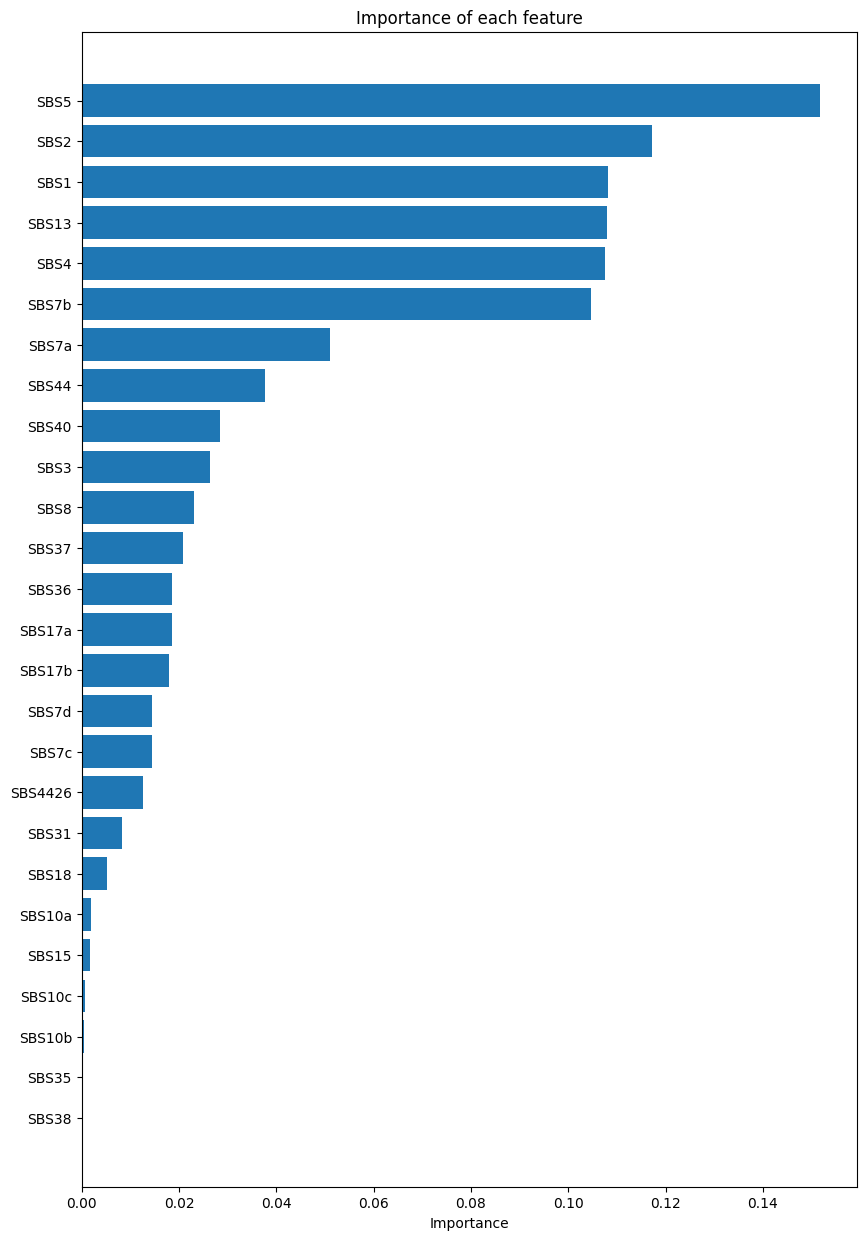

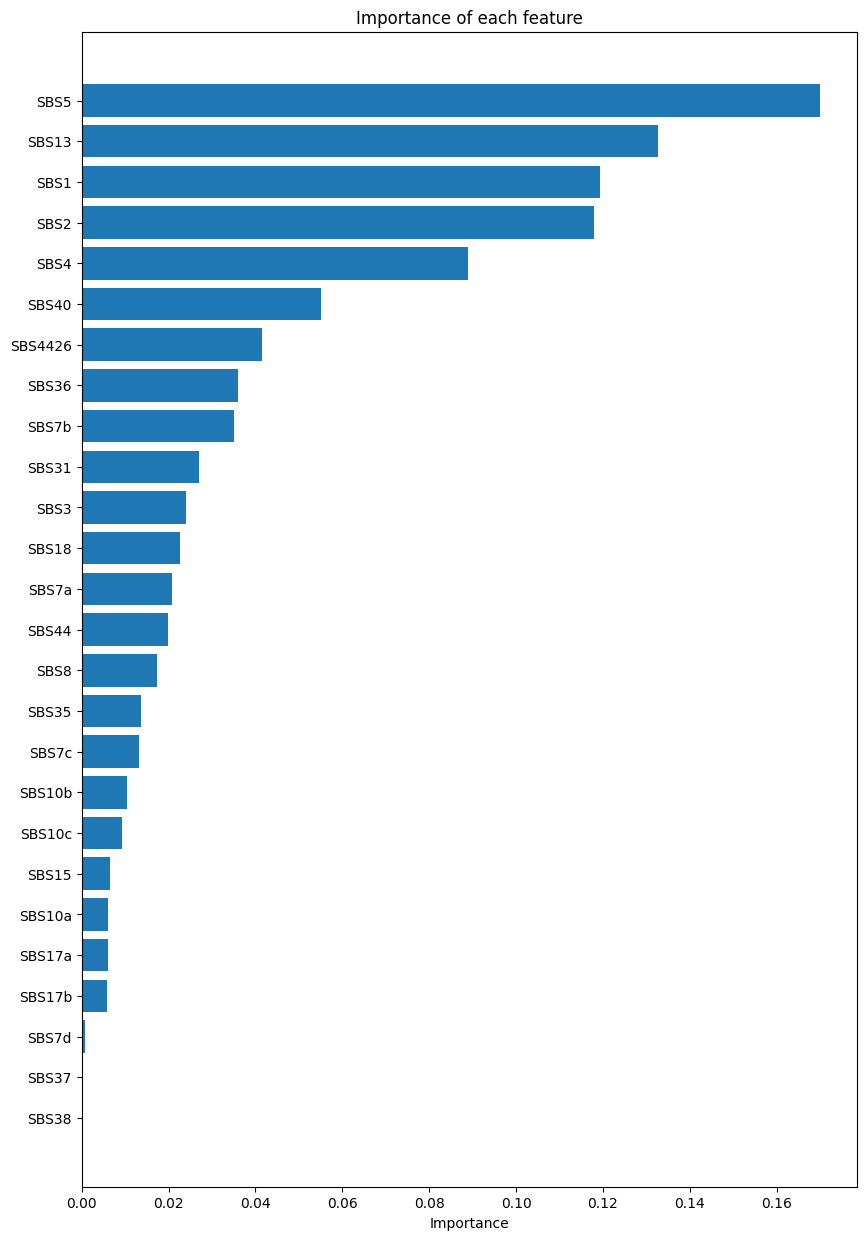

In [4]:
features_name_sbs = ["SBS1",
                     "SBS2",
                     "SBS3",
                     "SBS4",
                     "SBS5",
                     "SBS7a",
                     "SBS7b",
                     "SBS7c",
                     "SBS7d",
                     "SBS8",
                     "SBS10a",
                     "SBS10b",
                     "SBS10c",
                     "SBS13",
                     "SBS15",
                     "SBS17a",
                     "SBS17b",
                     "SBS18",
                     "SBS31",
                     "SBS35",
                     "SBS36",
                     "SBS37",
                     "SBS38",
                     "SBS40",
                     "SBS44",
                     "SBS4426"]

# Compute feature importance
# TTP :
features_name_sbs_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_sbs], y_clf_ttp, True)
features_name_sbs_os = FeatureSelector.feature_importance(df.loc[:, features_name_sbs], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_sbs):
    features_name_sbs_ttp = features_name_sbs_ttp[:n_features]
    features_name_sbs_os = features_name_sbs_os[:n_features]

# Extract features
X_sbs_ttp = df.loc[:, features_name_sbs_ttp].to_numpy()
X_sbs_os = df.loc[:, features_name_sbs_os].to_numpy()

#### Make the leave one out CV

In [5]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_sbs_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_sbs_ttp, risk_classes_sbs_ttp, nx_graph_sbs_ttp = manager_sbs_ttp.leave_one_out_cv(X_sbs_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_sbs_os = GNNCoxTrainTestManager(architecture)
risk_scores_sbs_os, risk_classes_sbs_os, nx_graph_sbs_os = manager_sbs_os.leave_one_out_cv(X_sbs_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 2. Only mutational signatures

#### Feature selection

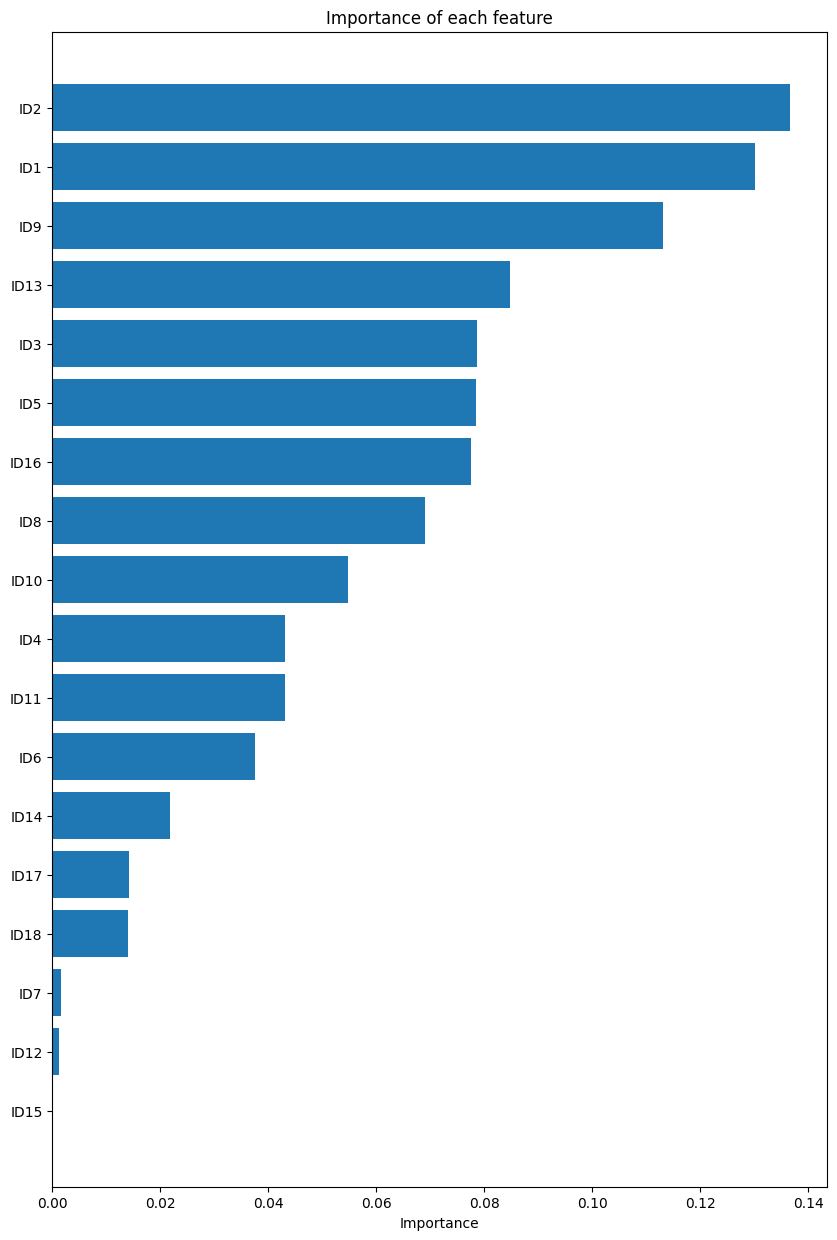

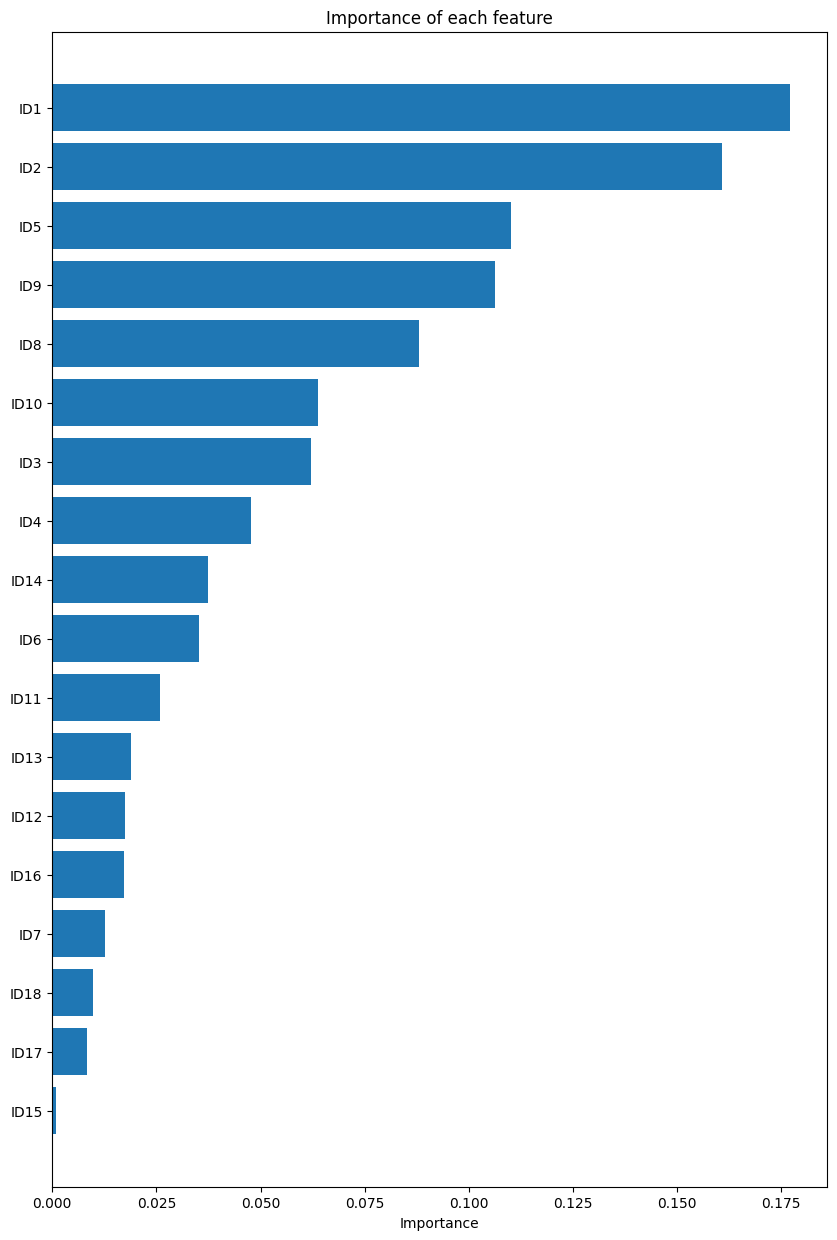

In [6]:
features_name_indel = ["ID1",
                       "ID2",
                       "ID3",
                       "ID4",
                       "ID5",
                       "ID6",
                       "ID7",
                       "ID8",
                       "ID9",
                       "ID10",
                       "ID11",
                       "ID12",
                       "ID13",
                       "ID14",
                       "ID15",
                       "ID16",
                       "ID17",
                       "ID18"]

# Compute feature importance
# TTP :
features_name_indel_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_indel], y_clf_ttp, True)
features_name_indel_os = FeatureSelector.feature_importance(df.loc[:, features_name_indel], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_indel):
    features_name_indel_ttp = features_name_indel_ttp[:n_features]
    features_name_indel_os = features_name_indel_os[:n_features]

# Extract features
X_indel_ttp = df.loc[:, features_name_indel_ttp].to_numpy()
X_indel_os = df.loc[:, features_name_indel_os].to_numpy()

#### Make the leave one out CV

In [7]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_indel_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_indel_ttp, risk_classes_indel_ttp, nx_graph_indel_ttp = manager_indel_ttp.leave_one_out_cv(X_indel_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_indel_os = GNNCoxTrainTestManager(architecture)
risk_scores_indel_os, risk_classes_indel_os, nx_graph_indel_os = manager_indel_os.leave_one_out_cv(X_indel_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 3. Initial biomarkers + mutational signatures

#### Feature selection

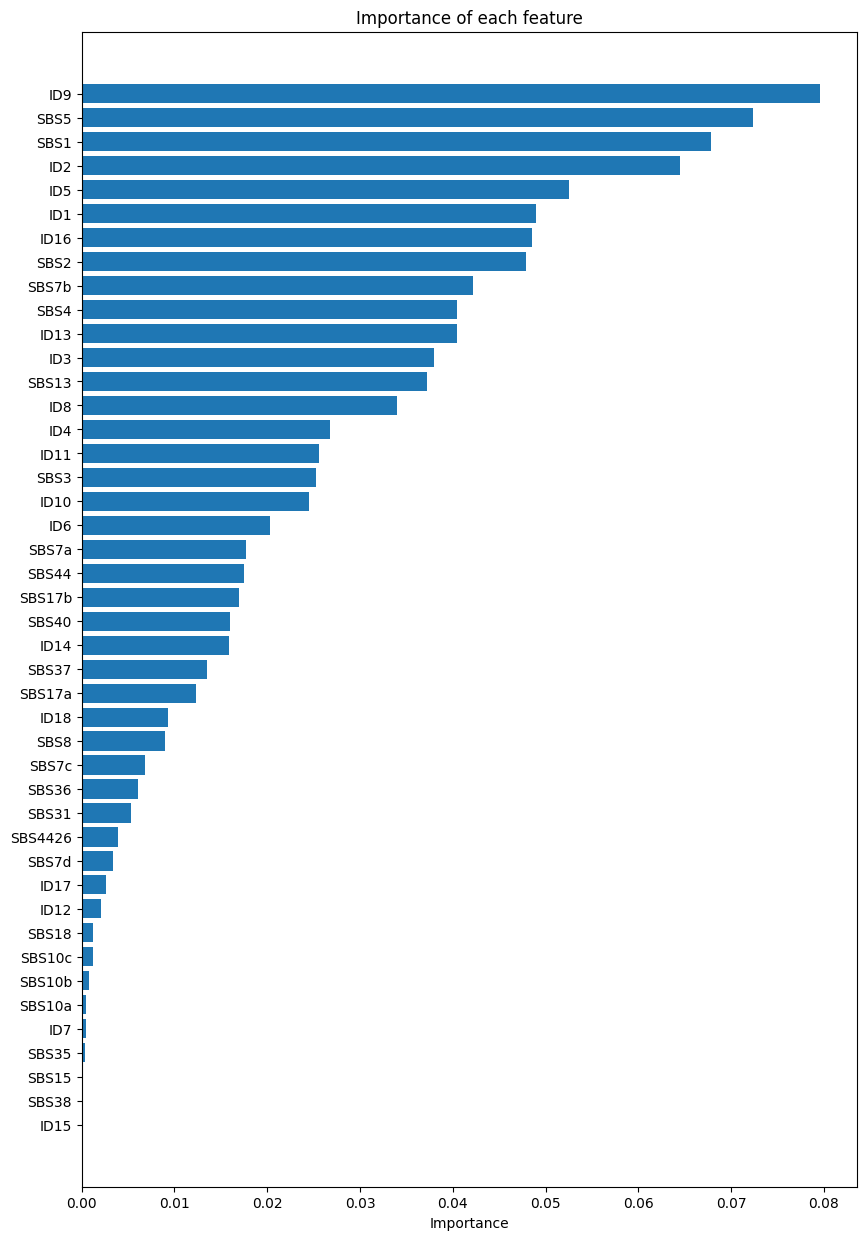

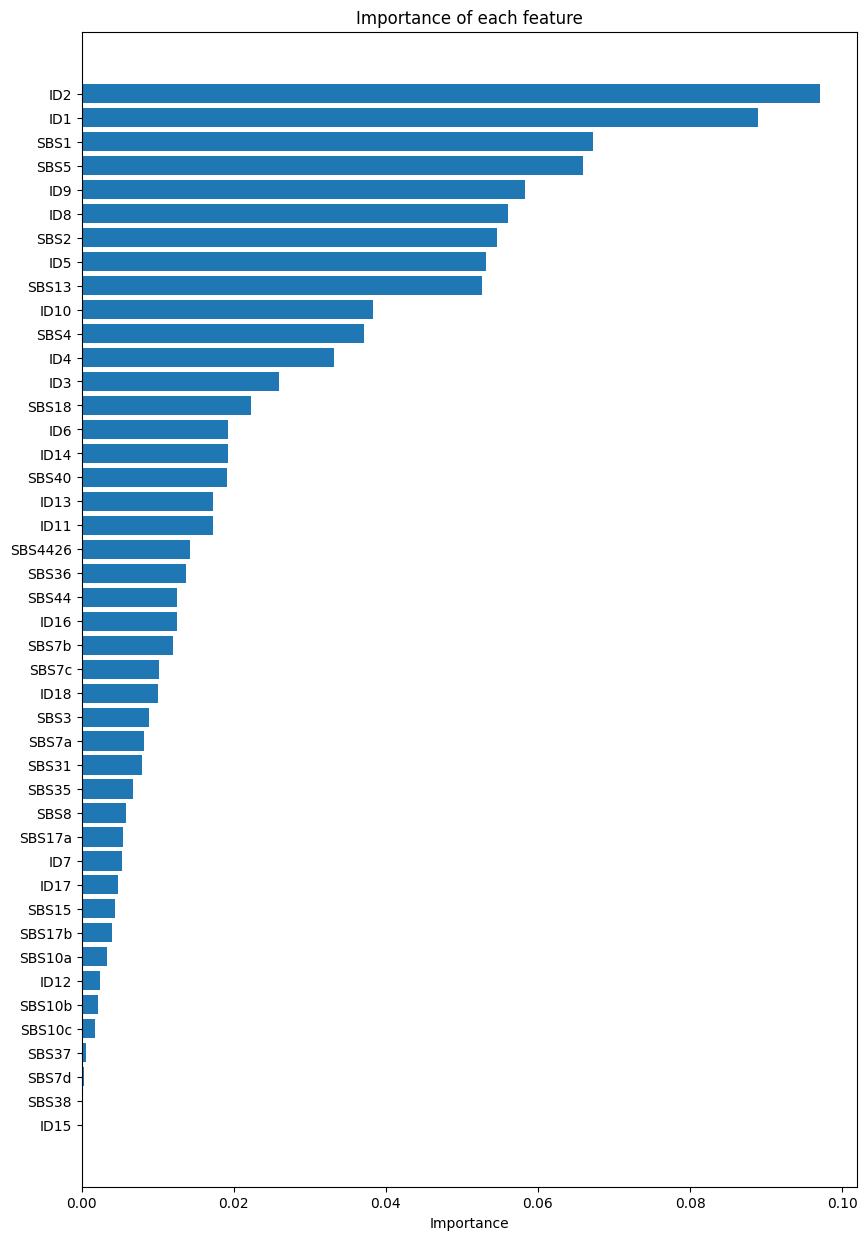

In [8]:
features_name_comb = ["SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
# TTP :
features_name_comb_ttp = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y_clf_ttp, True)
features_name_comb_os = FeatureSelector.feature_importance(df.loc[:, features_name_comb], y_clf_os, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb_ttp = features_name_comb_ttp[:n_features]
    features_name_comb_os = features_name_comb_os[:n_features]

# Extract features
X_comb_ttp = df.loc[:, features_name_comb_ttp].to_numpy()
X_comb_os = df.loc[:, features_name_comb_os].to_numpy()

#### Make the leave one out CV

In [9]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_comb_ttp = GNNCoxTrainTestManager(architecture)
risk_scores_comb_ttp, risk_classes_comb_ttp, nx_graph_comb_ttp = manager_comb_ttp.leave_one_out_cv(X_comb_ttp, y_clf_ttp, y_cox_ttp, group, n_epochs, lr, reg, max_neighbors)
# OS :
manager_comb_os = GNNCoxTrainTestManager(architecture)
risk_scores_comb_os, risk_classes_comb_os, nx_graph_comb_os = manager_comb_os.leave_one_out_cv(X_comb_os,y_clf_os, y_cox_os, group, n_epochs, lr, reg, max_neighbors)

### 4. Evaluate performances

In [10]:
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()

#### SHAP values

In [11]:
# SBS
pyg_graph_sbs_ttp = from_networkx(nx_graph_sbs_ttp)
pyg_graph_sbs_os = from_networkx(nx_graph_sbs_os)
# TTP :
explainer_sbs_ttp = Explainer(
    model=manager_sbs_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_sbs_ttp = explainer_sbs_ttp(pyg_graph_sbs_ttp.x, pyg_graph_sbs_ttp.edge_index)
# OS :
explainer_sbs_os = Explainer(
    model=manager_sbs_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_sbs_os = explainer_sbs_os(pyg_graph_sbs_os.x, pyg_graph_sbs_os.edge_index)

# INDEL
pyg_graph_indel_ttp = from_networkx(nx_graph_indel_ttp)
pyg_graph_indel_os = from_networkx(nx_graph_indel_os)
# TTP :
explainer_indel_ttp = Explainer(
    model=manager_indel_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_indel_ttp = explainer_indel_ttp(pyg_graph_indel_ttp.x, pyg_graph_indel_ttp.edge_index)
# OS :
explainer_indel_os = Explainer(
    model=manager_indel_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_indel_os = explainer_indel_os(pyg_graph_indel_os.x, pyg_graph_indel_os.edge_index)

# SBS + INDEL
pyg_graph_comb_ttp = from_networkx(nx_graph_comb_ttp)
pyg_graph_comb_os = from_networkx(nx_graph_comb_os)
# TTP :
explainer_comb_ttp = Explainer(
    model=manager_comb_ttp.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb_ttp = explainer_comb_ttp(pyg_graph_comb_ttp.x, pyg_graph_comb_ttp.edge_index)
# OS :
explainer_comb_os = Explainer(
    model=manager_comb_os.gnn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  
    ),
)
explanation_comb_os = explainer_comb_os(pyg_graph_comb_os.x, pyg_graph_comb_os.edge_index)

#### C-index

In [12]:
# SBS
c_index_sbs_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_sbs_ttp)
c_index_sbs_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_sbs_os)

# INDEL
c_index_indel_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_indel_ttp)
c_index_indel_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_indel_os)

# SBS + INDEL
c_index_comb_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_comb_ttp)
c_index_comb_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_comb_os)

#### Log rank test p value

In [13]:
# SBS
p_value_sbs_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_sbs_ttp)
p_value_sbs_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_sbs_os)

# INDEL
p_value_indel_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_indel_ttp)
p_value_indel_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_indel_os)

# SBS + INDEL
p_value_comb_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_comb_ttp)
p_value_comb_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_comb_os)

#### Kaplan Meier curves

In [14]:
# SBS
# TTP, low risk :
status_low_risk_sbs_ttp = status_ttp[np.where(risk_classes_sbs_ttp == 0)]
time_low_risk_sbs_ttp = time_ttp[np.where(risk_classes_sbs_ttp == 0)]
time_axis_low_risk_sbs_ttp, prob_axis_low_risk_sbs_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_sbs_ttp, time_low_risk_sbs_ttp)
# TTP, high risk :
status_high_risk_sbs_ttp = status_ttp[np.where(risk_classes_sbs_ttp == 1)]
time_high_risk_sbs_ttp = time_ttp[np.where(risk_classes_sbs_ttp == 1)]
time_axis_high_risk_sbs_ttp, prob_axis_high_risk_sbs_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_sbs_ttp, time_high_risk_sbs_ttp)
# OS, low risk :
status_low_risk_sbs_os = status_os[np.where(risk_classes_sbs_os == 0)]
time_low_risk_sbs_os = time_os[np.where(risk_classes_sbs_os == 0)]
time_axis_low_risk_sbs_os, prob_axis_low_risk_sbs_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_sbs_os, time_low_risk_sbs_os)
# OS, high risk :
status_high_risk_sbs_os = status_os[np.where(risk_classes_sbs_os == 1)]
time_high_risk_sbs_os = time_os[np.where(risk_classes_sbs_os == 1)]
time_axis_high_risk_sbs_os, prob_axis_high_risk_sbs_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_sbs_os, time_high_risk_sbs_os)

# INDEL
# TTP, low risk :
status_low_risk_indel_ttp = status_ttp[np.where(risk_classes_indel_ttp == 0)]
time_low_risk_indel_ttp = time_ttp[np.where(risk_classes_indel_ttp == 0)]
time_axis_low_risk_indel_ttp, prob_axis_low_risk_indel_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_indel_ttp, time_low_risk_indel_ttp)
# TTP, high risk :
status_high_risk_indel_ttp = status_ttp[np.where(risk_classes_indel_ttp == 1)]
time_high_risk_indel_ttp = time_ttp[np.where(risk_classes_indel_ttp == 1)]
time_axis_high_risk_indel_ttp, prob_axis_high_risk_indel_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_indel_ttp, time_high_risk_indel_ttp)
# OS, low risk :
status_low_risk_indel_os = status_os[np.where(risk_classes_indel_os == 0)]
time_low_risk_indel_os = time_os[np.where(risk_classes_indel_os == 0)]
time_axis_low_risk_indel_os, prob_axis_low_risk_indel_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_indel_os, time_low_risk_indel_os)
# OS, high risk :
status_high_risk_indel_os = status_os[np.where(risk_classes_indel_os == 1)]
time_high_risk_indel_os = time_os[np.where(risk_classes_indel_os == 1)]
time_axis_high_risk_indel_os, prob_axis_high_risk_indel_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_indel_os, time_high_risk_indel_os)

# SBS + INDEL
# TTP, low risk :
status_low_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 0)]
time_low_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 0)]
time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_ttp, time_low_risk_comb_ttp)
# TTP, high risk :
status_high_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 1)]
time_high_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 1)]
time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_ttp, time_high_risk_comb_ttp)
# OS, low risk :
status_low_risk_comb_os = status_os[np.where(risk_classes_comb_os == 0)]
time_low_risk_comb_os = time_os[np.where(risk_classes_comb_os == 0)]
time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_os, time_low_risk_comb_os)
# OS, high risk :
status_high_risk_comb_os = status_os[np.where(risk_classes_comb_os == 1)]
time_high_risk_comb_os = time_os[np.where(risk_classes_comb_os == 1)]
time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_os, time_high_risk_comb_os)

#### Plot results

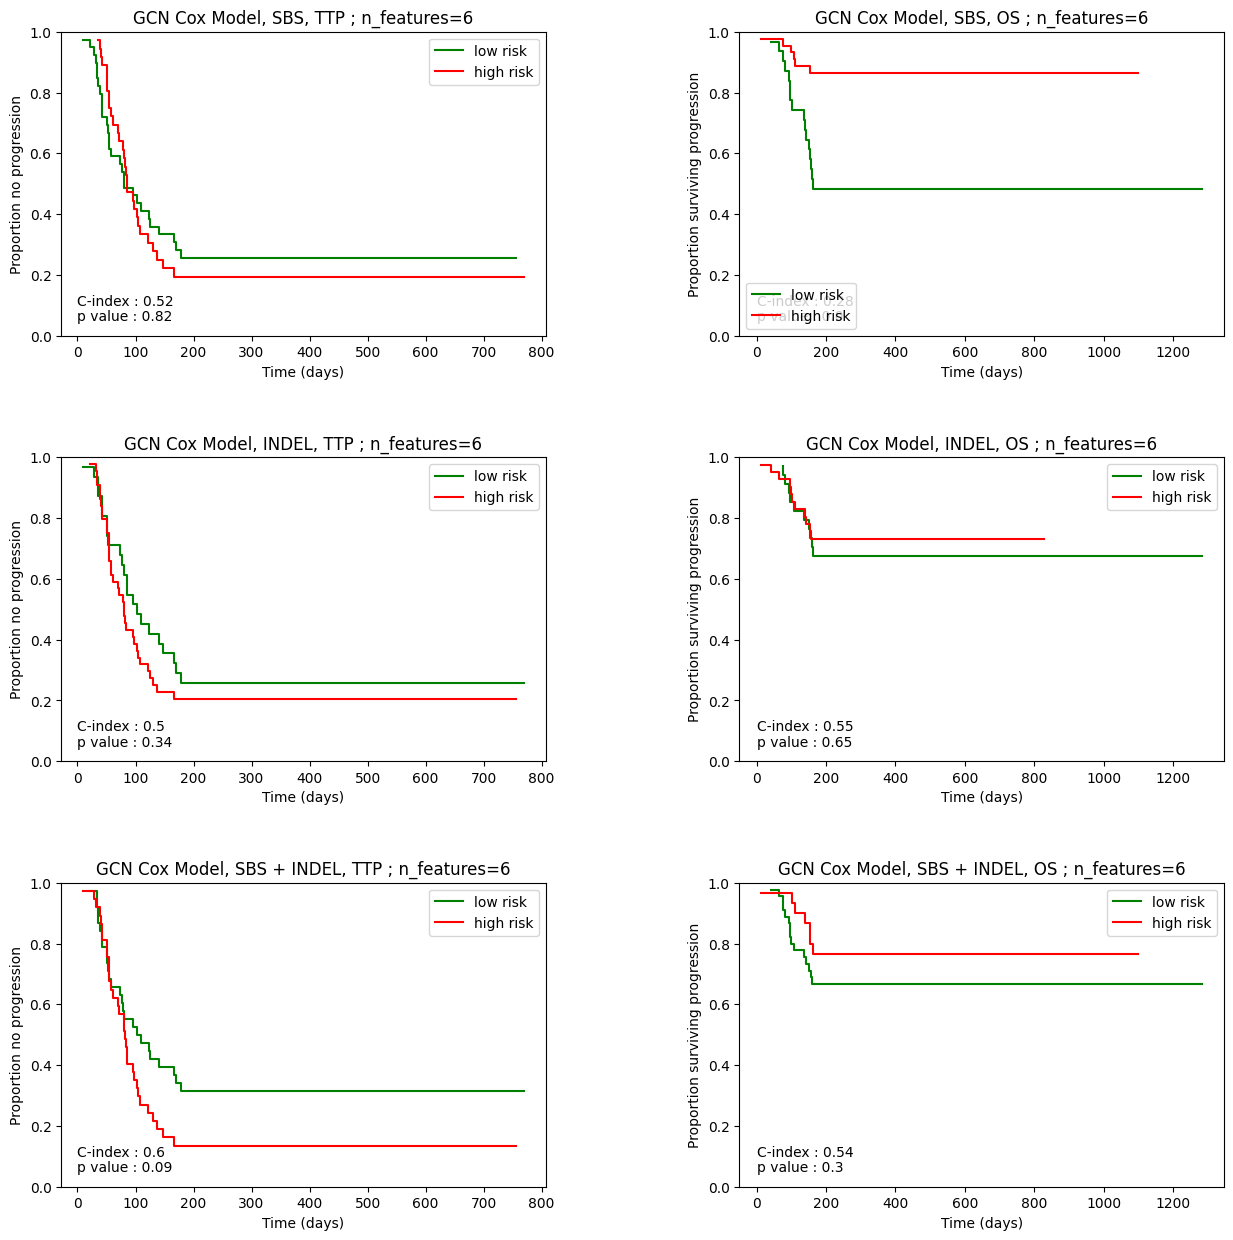

In [15]:
fig = plt.figure()

# SBS
# TTP :
ax0 = fig.add_subplot(321)
ax0.step(time_axis_low_risk_sbs_ttp, prob_axis_low_risk_sbs_ttp, where='post',color='green',label='low risk')
ax0.step(time_axis_high_risk_sbs_ttp, prob_axis_high_risk_sbs_ttp, where='post',color='red',label='high risk')
ax0.set_xlabel('Time (days)')
ax0.set_ylabel('Proportion no progression')
ax0.set_title(f'GCN Cox Model, SBS, TTP ; n_features={n_features}')
ax0.text(0,0.1,f'C-index : {c_index_sbs_ttp}')
ax0.text(0,0.05,f'p value : {p_value_sbs_ttp}')
ax0.set_ylim(0,1)
ax0.legend()

# OS :
ax1 = fig.add_subplot(322)
ax1.step(time_axis_low_risk_sbs_os, prob_axis_low_risk_sbs_os, where='post',color='green',label='low risk')
ax1.step(time_axis_high_risk_sbs_os, prob_axis_high_risk_sbs_os, where='post',color='red',label='high risk')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion surviving progression')
ax1.set_title(f'GCN Cox Model, SBS, OS ; n_features={n_features}')
ax1.text(0,0.1,f'C-index : {c_index_sbs_os}')
ax1.text(0,0.05,f'p value : {p_value_sbs_os}')
ax1.set_ylim(0,1)
ax1.legend()

# INDEL
# TTP :
ax3 = fig.add_subplot(323)
ax3.step(time_axis_low_risk_indel_ttp, prob_axis_low_risk_indel_ttp, where='post',color='green',label='low risk')
ax3.step(time_axis_high_risk_indel_ttp, prob_axis_high_risk_indel_ttp, where='post',color='red',label='high risk')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion no progression')
ax3.set_title(f'GCN Cox Model, INDEL, TTP ; n_features={n_features}')
ax3.text(0,0.1,f'C-index : {c_index_indel_ttp}')
ax3.text(0,0.05,f'p value : {p_value_indel_ttp}')
ax3.set_ylim(0,1)
ax3.legend()

# OS :
ax4 = fig.add_subplot(324)
ax4.step(time_axis_low_risk_indel_os, prob_axis_low_risk_indel_os, where='post',color='green',label='low risk')
ax4.step(time_axis_high_risk_indel_os, prob_axis_high_risk_indel_os, where='post',color='red',label='high risk')
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion surviving progression')
ax4.set_title(f'GCN Cox Model, INDEL, OS ; n_features={n_features}')
ax4.text(0,0.1,f'C-index : {c_index_indel_os}')
ax4.text(0,0.05,f'p value : {p_value_indel_os}')
ax4.set_ylim(0,1)
ax4.legend()

# SBS + INDEL
# TTP :
ax6 = fig.add_subplot(325)
ax6.step(time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp, where='post',color='green',label='low risk')
ax6.step(time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp, where='post',color='red',label='high risk')
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion no progression')
ax6.set_title(f'GCN Cox Model, SBS + INDEL, TTP ; n_features={n_features}')
ax6.text(0,0.1,f'C-index : {c_index_comb_ttp}')
ax6.text(0,0.05,f'p value : {p_value_comb_ttp}')
ax6.set_ylim(0,1)
ax6.legend()

# OS :
ax7 = fig.add_subplot(326)
ax7.step(time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os, where='post',color='green',label='low risk')
ax7.step(time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os, where='post',color='red',label='high risk')
ax7.set_xlabel('Time (days)')
ax7.set_ylabel('Proportion surviving progression')
ax7.set_title(f'GCN Cox Model, SBS + INDEL, OS ; n_features={n_features}')
ax7.text(0,0.1,f'C-index : {c_index_comb_os}')
ax7.text(0,0.05,f'p value : {p_value_comb_os}')
ax7.set_ylim(0,1)
ax7.legend()

plt.gcf().set_size_inches(15,15)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

SBS TTP :


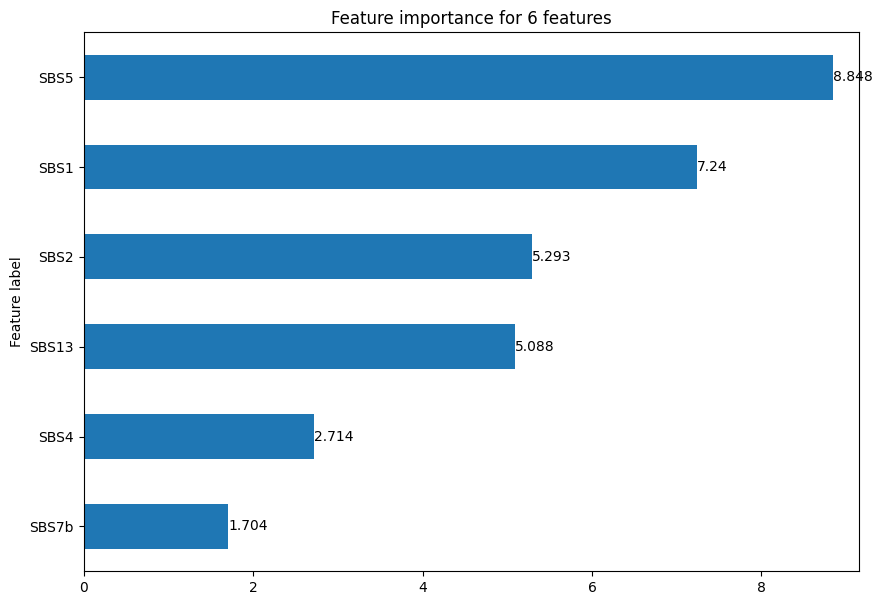

SBS OS :


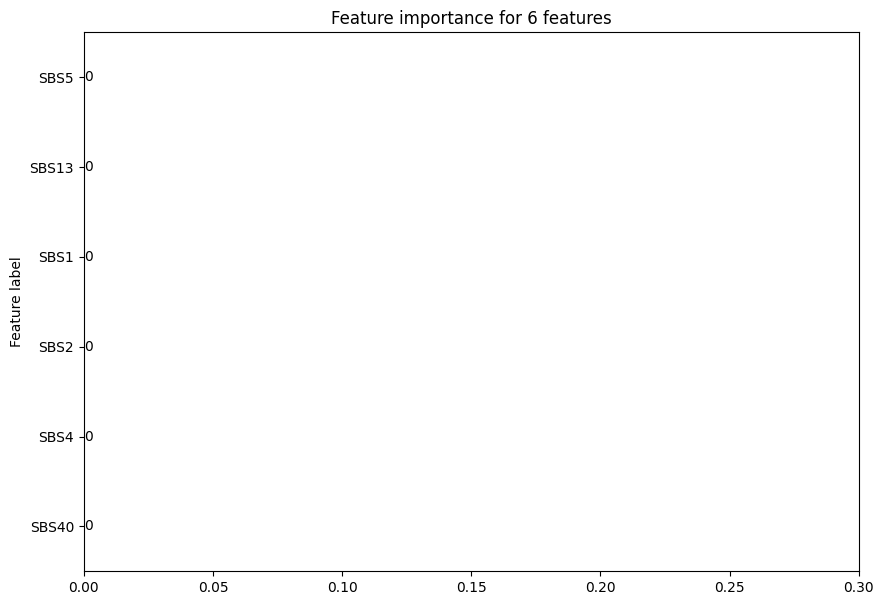

INDEL TTP :


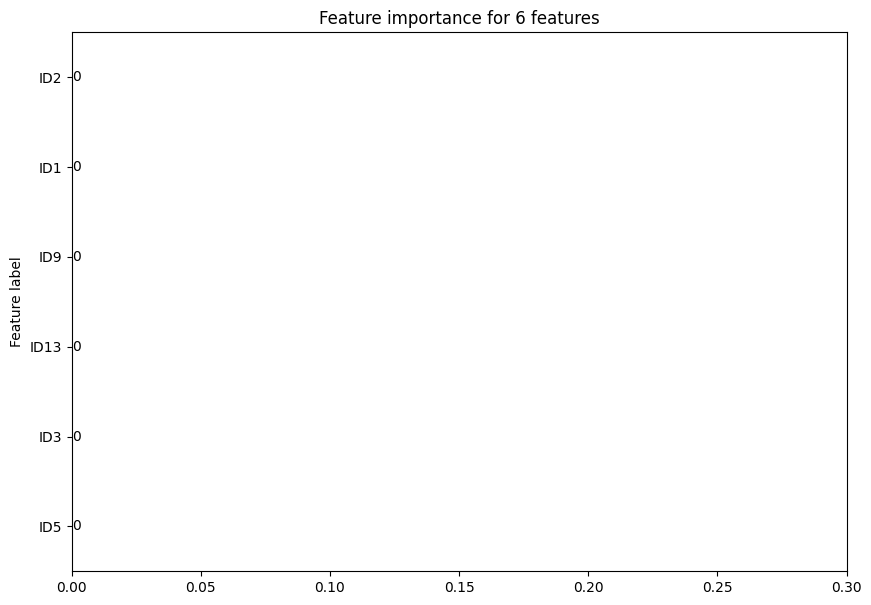

INDEL OS :


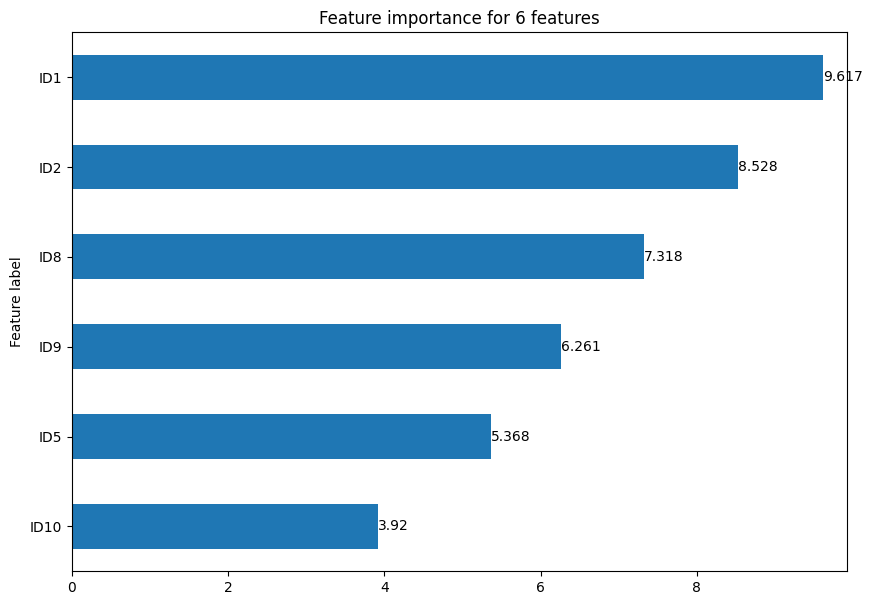

SBS + INDEL TTP


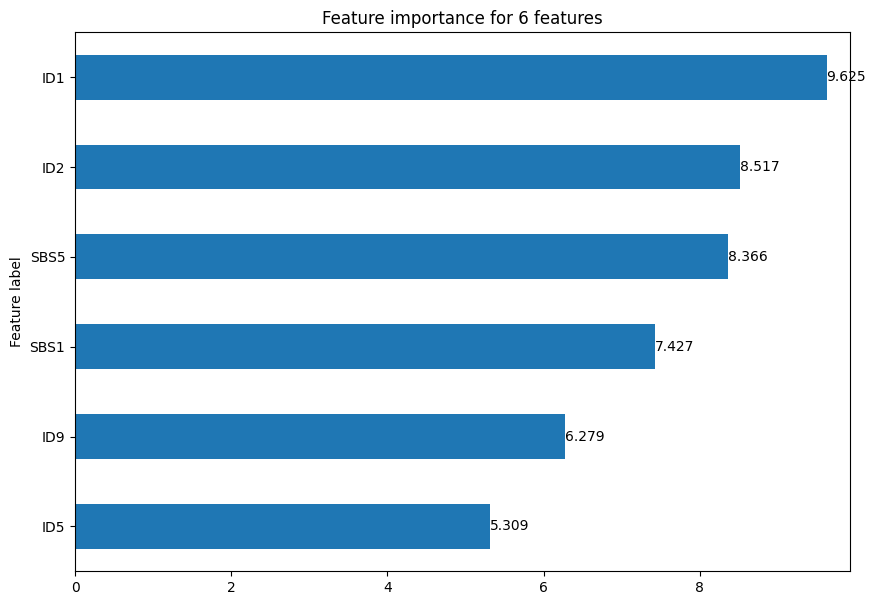

SBS + INDEL OS


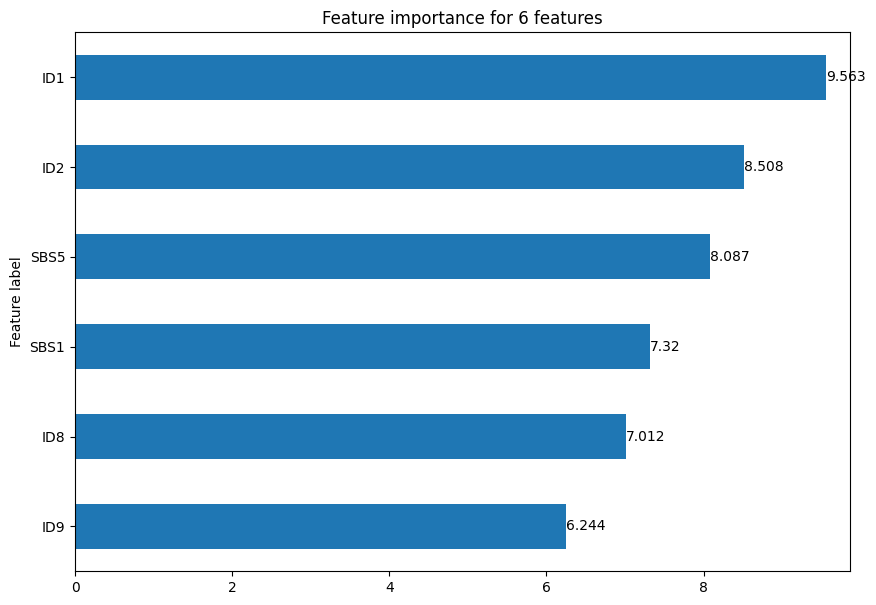

In [16]:
print("SBS TTP :")
explanation_sbs_ttp.visualize_feature_importance(feat_labels=features_name_sbs_ttp)

print("SBS OS :")
explanation_sbs_os.visualize_feature_importance(feat_labels=features_name_sbs_os)

print("INDEL TTP :")
explanation_indel_ttp.visualize_feature_importance(feat_labels=features_name_indel_ttp)

print("INDEL OS :")
explanation_indel_os.visualize_feature_importance(feat_labels=features_name_indel_os)

print("SBS + INDEL TTP")
explanation_comb_ttp.visualize_feature_importance(feat_labels=features_name_comb_ttp)

print("SBS + INDEL OS")
explanation_comb_os.visualize_feature_importance(feat_labels=features_name_comb_os)